# SHAP and Shapley using Taiwan Credit Default data

## Exploratory Data Analysis

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True) 
import plotly.graph_objs as go 
import plotly.tools as tls 
from collections import Counter

In [2]:
# Read the data 
taiwan = pd.read_csv('taiwan_credit_defaults.csv')

In [3]:
# Short clean
taiwan.rename(columns = {'PAY_0':'PAY_1'}, inplace = True)  # Rename columns for more consistent analysis
taiwan.rename(columns = {'default payment next month':'default_payment_next_month'}, inplace = True)
taiwan = taiwan.drop('ID', 1)  # Remove the ID column which is just a numeric from 1 to 30,000

### Basic Information

Here, we are just looking at the size of the data set, features, null values, data types, and number of unique values for each feature

In [4]:
taiwan.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
taiwan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_1                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

**Information regarding each attribute:**
- Begins April 2005 through September 2005
- LIMIT_BAL is amount of given credit
- SEX (1 is Male, 2 is Female)
- EDUCATION (1 = Graduate School, 2 = University, 3 = High School, 4 = Other)
- MARRIAGE (1 = Married, 2 = Single, 3 = Other)
- AGE
- PAY_1 through PAY_6: History of past payment results (-1 = pay duly, 1 = payment delay for one month; 2 = payment delay for two months...)
- BILL_AMT1 through BILL_AMT6: Amount of bill statement (BILL_AMT1 = September bill, BILL_AMT2 = August bill, etc.)
- PAY_AMT1 through PAY_AMT6: Amount paid (PAY_AMT1 = September paid amount, PAY_AMT2 = August paid amount, etc.)
- default_payment_next_month: Binary variable (1 = Defaulted, 0 = Not Defaulted)

In [10]:
taiwan.isnull().sum().sort_values(ascending=False)

LIMIT_BAL                     0
SEX                           0
PAY_AMT6                      0
PAY_AMT5                      0
PAY_AMT4                      0
PAY_AMT3                      0
PAY_AMT2                      0
PAY_AMT1                      0
BILL_AMT6                     0
BILL_AMT5                     0
BILL_AMT4                     0
BILL_AMT3                     0
BILL_AMT2                     0
BILL_AMT1                     0
PAY_6                         0
PAY_5                         0
PAY_4                         0
PAY_3                         0
PAY_2                         0
PAY_1                         0
AGE                           0
MARRIAGE                      0
EDUCATION                     0
default_payment_next_month    0
dtype: int64

### Distributional Analysis

I look at the distributions of different features to see whether there are any biases among different subsets of the data

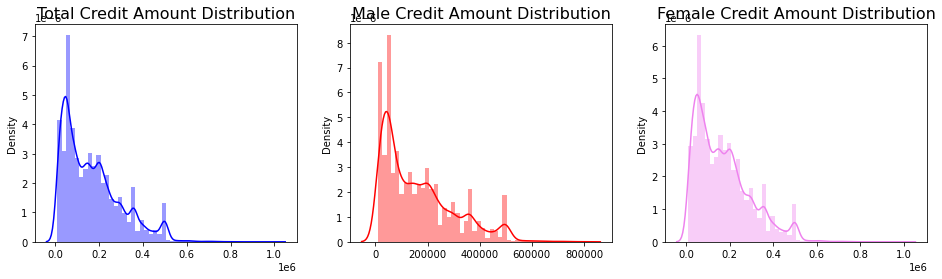

In [21]:
overall_credit = taiwan['LIMIT_BAL'].values  # Total credit amounts
male_credit = taiwan[taiwan['SEX'] == 1]['LIMIT_BAL'].values  # Credit amounts of male
female_credit = taiwan[taiwan['SEX'] == 2]['LIMIT_BAL'].values  # Credit amounts of female

fig, ax = plt.subplots(1, 3, figsize=(16,4))  # Define subplots - 1 row 3 column
sns.distplot(overall_credit, ax=ax[0], color= 'blue')
ax[0].set_title("Total Credit Amount Distribution", fontsize=16)  # Distribution plot of total credit amounts
sns.distplot(male_credit, ax=ax[1], color="red")  # Distribution plot of male credit amounts
ax[1].set_title("Male Credit Amount Distribution", fontsize=16)
sns.distplot(female_credit, ax=ax[2], color="violet")  # Distribution plot of female credit amounts
ax[2].set_title("Female Credit Amount Distribution", fontsize=16)
plt.show()

Seems like the data is evenly distributed among males and females. Males do on average receive more credit - careful with the axes! Axes are not evenly matched.

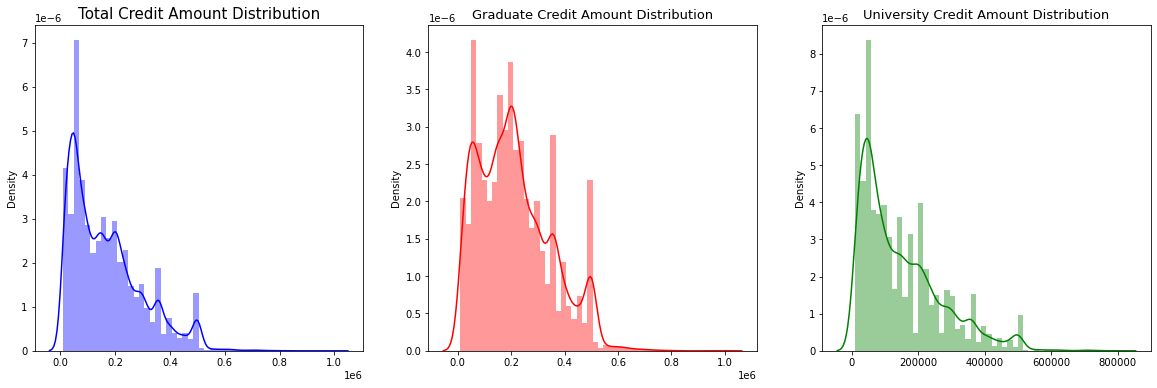

In [17]:
overall_credit = taiwan['LIMIT_BAL'].values  # Total credit amounts
graduate = taiwan[taiwan['EDUCATION'] == 1]['LIMIT_BAL'].values  # Credit amounts of graduate education
university = taiwan[taiwan['EDUCATION'] == 2]['LIMIT_BAL'].values  # Credit amounts of university education
high_school = taiwan[taiwan['EDUCATION'] == 3]['LIMIT_BAL'].values  # Credit amounts of high school education
other = taiwan[taiwan['EDUCATION'] == 4]['LIMIT_BAL'].values  # Credit amounts of other education

fig, ax = plt.subplots(1, 3, figsize=(20,6))  # Define subplots - 1 row 4 column
sns.distplot(overall_credit, ax=ax[0], color= 'blue')  # Distribution plot of total credit amounts
ax[0].set_title("Total Credit Amount Distribution", fontsize=15) 
sns.distplot(graduate, ax=ax[1], color="red")  # Distribution plot of Graduate credit amounts
ax[1].set_title("Graduate Credit Amount Distribution", fontsize=13)
sns.distplot(university, ax=ax[2], color="green")  # Distribution plot of University credit amounts
ax[2].set_title("University Credit Amount Distribution", fontsize=13)
plt.show()

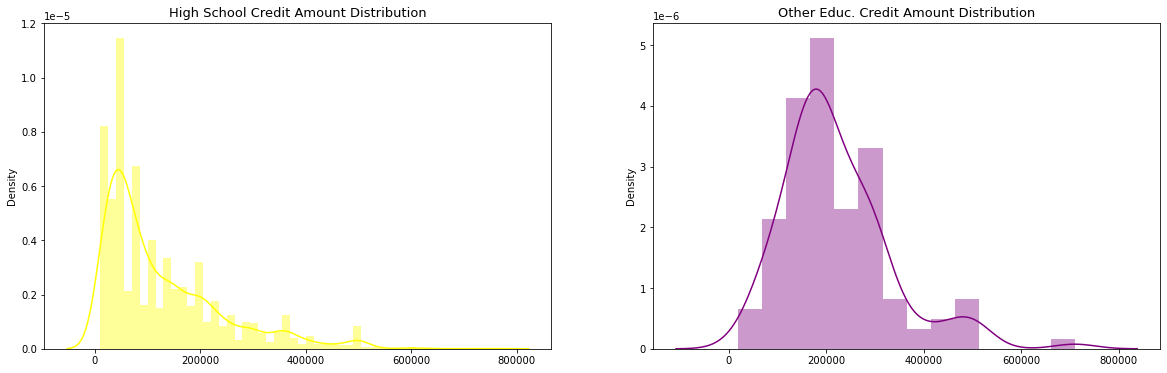

In [19]:
overall_credit = taiwan['LIMIT_BAL'].values  # Total credit amounts
graduate = taiwan[taiwan['EDUCATION'] == 1]['LIMIT_BAL'].values  # Credit amounts of graduate education
university = taiwan[taiwan['EDUCATION'] == 2]['LIMIT_BAL'].values  # Credit amounts of university education
high_school = taiwan[taiwan['EDUCATION'] == 3]['LIMIT_BAL'].values  # Credit amounts of high school education
other = taiwan[taiwan['EDUCATION'] == 4]['LIMIT_BAL'].values  # Credit amounts of other education

fig, ax = plt.subplots(1, 2, figsize=(20,6))  # Define subplots - 1 row 4 column
sns.distplot(high_school, ax=ax[0], color="yellow")  # Distribution plot of High School credit amounts
ax[0].set_title("High School Credit Amount Distribution", fontsize=13)
sns.distplot(other, ax=ax[1], color="purple")  # Distribution plot of Other Educ. credit amounts
ax[1].set_title("Other Educ. Credit Amount Distribution", fontsize=13)
plt.show()

In [34]:
avg_credit_graduate = np.median(graduate)
avg_credit_university = np.median(university)
avg_credit_high_school = np.median(high_school)

print(f"Median credit received for a person with a graduate degree is {avg_credit_graduate}")
print(f"Median credit received for a person with a university degree is {avg_credit_university}")
print(f"Median credit received for a person with a high school degree is {avg_credit_high_school}")

Median credit received for a person with a graduate degree is 200000.0
Median credit received for a person with a university degree is 110000.0
Median credit received for a person with a high school degree is 80000.0


People with a graduate degree are typically able to receive much higher lines of credit than those with a university or high school degree. 

### Target Variable Distribution

We can see whether the target variable distribution is balanced

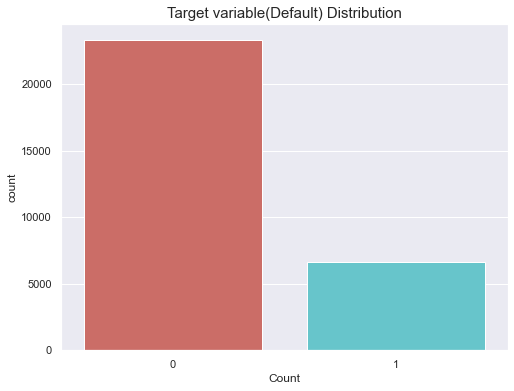

In [36]:
sns.set(rc = {'figure.figsize':(8,6)})
g1 = sns.countplot(x="default_payment_next_month",data= taiwan, palette="hls")                  
g1.set_title("Target variable(Default) Distribution", fontsize=15)
g1.set_xlabel("Default")
g1.set_xlabel("Count")
plt.show()

As we can see, not defaulting occurs at a rate 4 times as often as defaulting does. While we do not have a balanced data set, there are enough counts in each case where we can continue with our analysis

### Distribution of age among people who defaulted/not defaulted

In [39]:
df_default = taiwan.loc[taiwan["default_payment_next_month"] == 1]['AGE'].values.tolist()  # Age of people who defaulted
df_not_default = taiwan.loc[taiwan["default_payment_next_month"] == 0]['AGE'].values.tolist()  # Age of people who didn't default
df_age = taiwan['AGE'].values.tolist()

# Age distribution of people who defaulted
trace0 = go.Histogram(
    x=df_default,
    histnorm='probability',
    name="Defaulted"
)
# Age distribution of people who did not default
trace1 = go.Histogram(
    x=df_not_default,
    histnorm='probability',
    name="Not Defaulted"
)
# Age distribution of people in the dataset
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Defaulted','Not Defaulted', 'Overall Age Distribuition'))

#Setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribution', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

/Users/Ivan/opt/anaconda3/lib/python3.9/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



All seem to be the same age, consistent results.

### Regression Plots

In [ ]:
sns.lmplot(x="LIMIT_BAL",y="Duration", hue="Housing", data=taiwan, palette="Set1", aspect=2) # Linear relationship between credit amount and duration variables with housing seperation
plt.title('Regression Plot for Duration and Credit Amount with Housing categorization', fontsize=17)
plt.show()